# German Traffic Sign Image Classification

## Josh Wacholz

## Table of Contents
1. Background
2. Goal
3. Source Data
4. Initial Review of the Data
5. Data Wrangling
6. Deep Learning Methodologies
7. Overall Conclusions and Recommendations

## 1. Background

Self driving cars are the future. For cars to be fully autonomous, they need to be able to classify all kinds of objects. Most importantly, they need to learn and understand all of the different traffic signs quickly and accurately so that they can make decisions about what to do when a traffic sign is detected.

Disclaimer: I had no idea that my project was going to be used as an example in chapter 12 of the Deep Learning For Dummies book. The code in the book was helpful though in getting my neural networks to run properly using Colab.

## 2. Goal

My goal for the project was to build a convolutional neural network that can classify images of German traffic signs with more accuracy than a simple, baseline CNN and approach the 99% accuracy obtained by the example in the book. Also, I wanted to show the effect that different techniques have on model performance. Also, I wanted to try using a pre-trained convnet to see the results.

## 3. Source Data

The German Traffic Sign Recognition Benchmark

https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html

## 4. Initial Review of the Data

The dataset has 43 unique classes of traffic signs. They are images of German traffic signs along stretches of highway driven by the initial research team. 

My original plan was to use the data in the train.csv and test.csv files which consisted of features that described the height and width of the image, as well as 2 sets of X, Y coordinates. However, I changed my mind and decided to use the actual images themselves. I downloaded the final training images zip folder from the website linked below and then uploaded that zipfile into Colab.

The dataset contains 39,209 color images of differing sizes, belonging to 43 different classes. This the actual training set used to train the neural network in the original research done by Stallkamp, Schlipsing, Salmen, and Igel. My project will divide this training set up into training and test sets instead of using the set of test images that the researchers used.

The classes are imbalanced due to the frequency of certain signs on the roads, but each have a minimum of 210 images in them. The most images in any one class is 2250. It should be noted that the original researchers stratified the dataset to ensure that each class was represented. They also discarded classes with fewer than 30 images.

## 5. Data Wrangling

I had some difficulty in getting the images in to Colab to work with them effectively. First I tried uploading the train and test image directories into my Google Drive and then mounting it here in order to use Keras' ImageDataGenerator flow_from_directory method. This proved to be unrealisticly slow when running just a baseline neural network. After some deliberation, I used the code that the textbook uses, with some modifications, to read each file from the zip file that I uploaded into Colab that contained the final training images. The code reads each file path and separates each file into the appropriate variable. The end result are x_train, x_test, y_train, and y_test variables containing a number of images and their class label, based on the 'test_size' variable.

The zip file was obtained from here (GTSRB_Final_Training_Images.zip): https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html

In [ ]:
# Code from pg 225 and 226 of the Deep Learning For Dummies book
# It opens the zipped file containing the training images and assigns the image
# and its label according to the if/else logic in the for loop below.
# The end result is training/test split of 80/20.  

import numpy as np
import zipfile
from skimage.transform import resize
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

img_size = 32
test_size = 0.2

x_train, x_test, y_train, y_test = list(), list(), list(), list()

archive = zipfile.ZipFile('./GTSRB_Final_Training_Images.zip', 'r')

file_paths = [file for file in archive.namelist() if '.ppm' in file]

for filename in file_paths:
  img = imread(archive.open(filename))
  img = resize(img, 
               output_shape=(img_size, img_size), 
               mode='reflect')
  img_class = int(filename.split('/')[-2])
  
  if(hash(filename) % 1000) / 1000 > test_size:
    x_train.append(img)
    y_train.append(img_class)
  else:
    x_test.append(img)
    y_test.append(img_class)

archive.close()

In [ ]:
# Observe the number of images/labels in the Train and Test set and verify that
# the test ratio is equal to the test_size variable

test_ratio = len(x_test) / len(file_paths)
print("Train size:", len(x_train))
print("Test size:", len(x_test))
print("Test ratio: {:.2f}".format(test_ratio))

Train size: 31184
Test size: 8025
Test ratio: 0.20


Number of Classes: 43


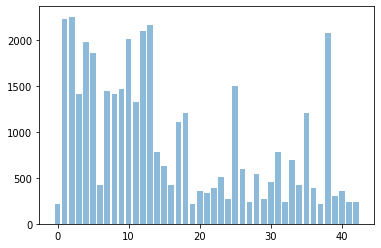

In [ ]:
# Observe the number of images/labels in each class

classes, dist = np.unique(y_train + y_test, return_counts=True)
num_classes = len(classes)
print("Number of Classes: {}".format(num_classes))

plt.bar(classes, dist, align='center', alpha=0.5)
plt.show()

In [ ]:
# Show which class has the most images/labels, and which class has the least

class_counts = dict(zip(classes,dist))
max_count = max(class_counts.values())
max_key = max(class_counts, key=class_counts.get)
print("Class with the most images:", max_key, ",", max_count)

min_count = min(class_counts.values())
min_key = min(class_counts, key=class_counts.get)
print("Class with the least images:", min_key, ",", min_count)

Class with the most images: 2 , 2250
Class with the least images: 0 , 210


The class weight is a ratio based on class frequencies that the neural network uses to icnrease the signal from rarer class examples and to get rid of more frequent one.

In [ ]:
# Calculate the class weight by dividing each class count by the sum of all class counts

class_weight = {c:dist[c]/np.sum(dist) for c in classes}

## 6. Deep Learning Methodologies

In [ ]:
# Import modules needed for CNNs and models

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import (Flatten, Dense, Dropout)

First, I had to decide what metrics to use for this problem. The book only uses accuracy in their example, which automatically defaults to the correct accuracy based on the loss function chosen. Since this is a multi-class classification problem, I was curious to see what the categorical accuracy (In this case, 'accuracy' defaults to this because of using the categorical crossentropy loss function), precision, recall, and AUC were for each model. I was also interested in observing the top k (3) categorical accuracy which counts the prediction as correct if one out of the top 'k' predicted classes is the correct class.

In [ ]:
# Use functools to get the top k categorical accuracy and save to a variable
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

# Define the metrics to use
METRICS = [
      keras.metrics.CategoricalAccuracy(name='cat_acc'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      top3_acc,
      'accuracy'
]

The 3 baseline models use a single instance of an ImageDataGenerator to simply rescale each image, with no data augmentation. The first baseline model consists of one Conv2D layer, a Flatten layer, and a Dense layer of 43 neurons, matching the number of classes, with a softmax activation to provide probability outputs for each class. I chose a standard batch size of 32 to start. This model has 1,239,339 trainable parameters.

### Baseline Model

In [ ]:
batch_size = 32

dgen = ImageDataGenerator(rescale = 1./255.)

train_generator = dgen.flow(
    np.array(x_train),
    to_categorical(y_train),
    batch_size = batch_size
)

test_generator = dgen.flow(
    np.array(x_test),
    to_categorical(y_test),
    batch_size = batch_size
)

In [ ]:
# Define the model layers and compile
def baseline_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(img_size, img_size, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = baseline_model()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=METRICS)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 43)                1238443   
                                                                 
Total params: 1,239,339
Trainable params: 1,239,339
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model
history = model.fit(train_generator,
                    validation_data = test_generator,
                    epochs = 50,
                    verbose = 0)

In [ ]:
# Evaluate the model on test images/labels from the test generator and observe metrics values
baseline_results = model.evaluate(test_generator, batch_size=batch_size, verbose=1)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)

244/244 [==============================] - 2s 9ms/step - loss: 0.2524 - cat_acc: 0.9488 - precision: 0.9601 - recall: 0.9413 - auc: 0.9937 - top3_acc: 0.9853 - accuracy: 0.9488
loss :  0.25243934988975525
cat_acc :  0.948846161365509
precision :  0.9601150751113892
recall :  0.9412820339202881
auc :  0.9937134385108948
top3_acc :  0.9852564334869385
accuracy :  0.948846161365509


Best validation accuracy: 0.965


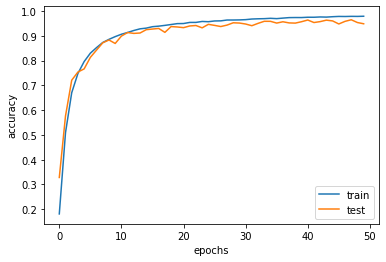

In [ ]:
# Plot the accuracy and validation accuracy metrics for both training and test sets
print("Best validation accuracy: {:0.3f}".format(np.max(history.history['val_accuracy'])))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

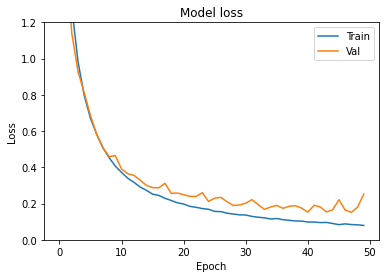

In [ ]:
# Plot the traing and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylim(top=1.2, bottom=0)
plt.show()

### Baseline Model with Class weights and 2nd convolutional layer

This model simply adds a 2nd Conv2D layer with 64 filters and uses the class weight value in the fit method to see the effect it has on the metrics. The number of trainable parameters increases to 2,177,003.

In [ ]:
# Add a 2nd Conv2D layer with 64 filters
def baseline_model2():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    return model

model2 = baseline_model2()
model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=METRICS)
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 43)                2157611   
                                                                 
Total params: 2,177,003
Trainable params: 2,177,003
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model, add the class_weight parameter
history2 = model2.fit(
    train_generator,
    validation_data = test_generator,
    class_weight = class_weight,
    epochs = 50,
    verbose = 0)

In [ ]:
# Evaluate the model on validation images/labels and observe metrics values
baseline_results2 = model2.evaluate(test_generator, batch_size=batch_size, verbose=1)
for name, value in zip(model2.metrics_names, baseline_results2):
  print(name, ': ', value)

251/251 [==============================] - 3s 10ms/step - loss: 0.2108 - cat_acc: 0.9755 - precision: 0.9762 - recall: 0.9752 - auc: 0.9940 - top3_acc: 0.9930 - accuracy: 0.9755
loss :  0.21076259016990662
cat_acc :  0.9754517078399658
precision :  0.9761756062507629
recall :  0.9752025008201599
auc :  0.9940212368965149
top3_acc :  0.9930217862129211
accuracy :  0.9754517078399658


Best validation accuracy: 0.976


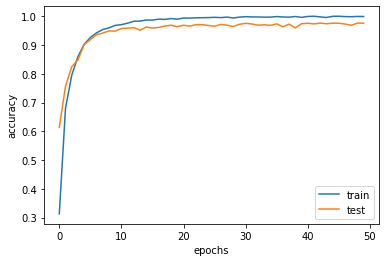

In [ ]:
# Plot the training and validation accuracy

print("Best validation accuracy: {:0.3f}".format(np.max(history2.history['val_accuracy'])))

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

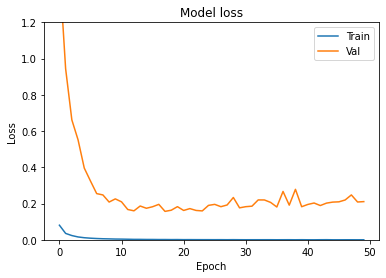

In [ ]:
# Plot the training and validation loss

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylim(top=1.2, bottom=0)
plt.show()

### Baseline Model with MaxPooling and Dropout layers

This model adds a MaxPooling2D and Dropout layer to help combat overfitting that was evident in the last model. Note how the MaxPooling2D and Dropout layers reduce the amount of trainable parameters from 2,177,003 to 558,827.

In [ ]:
# reset class weight
# Calculate the class weight by dividing each class count by the sum of all class counts
class_weight = {c:dist[c]/np.sum(dist) for c in classes}

# add MaxPooling2D and Dropout Layers
def baseline_model3():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model3 = baseline_model3()
model3.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=METRICS)
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dropout (Dropout)           (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 43)                539435    
                                                      

In [ ]:
# Fit the model
history3 = model3.fit(
    train_generator,
    validation_data = test_generator,
    class_weight = class_weight,
    epochs = 50,
    verbose = 0)

In [ ]:
# Evaluate the model based on test images/labels and observe the metrics
baseline_results3 = model3.evaluate(test_generator, batch_size=batch_size, verbose=1)
for name, value in zip(model3.metrics_names, baseline_results3):
  print(name, ': ', value)

244/244 [==============================] - 2s 10ms/step - loss: 0.1058 - cat_acc: 0.9813 - precision: 0.9829 - recall: 0.9797 - auc: 0.9968 - top3_acc: 0.9951 - accuracy: 0.9813
loss :  0.10579825192689896
cat_acc :  0.9812820553779602
precision :  0.9828938841819763
recall :  0.9797435998916626
auc :  0.9967831373214722
top3_acc :  0.9951282143592834
accuracy :  0.9812820553779602


Best validation accuracy: 0.984


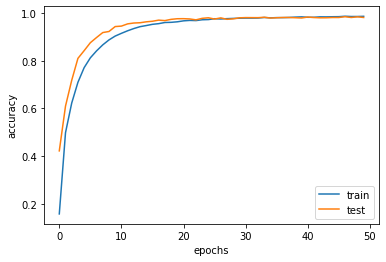

In [ ]:
# Plot the training and validiation accuracy
print("Best validation accuracy: {:0.3f}".format(np.max(history3.history['val_accuracy'])))

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

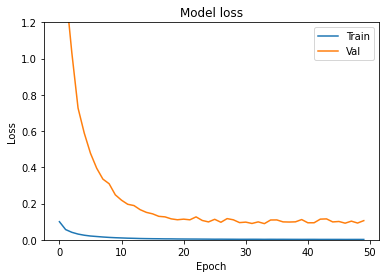

In [ ]:
# Plot the training and validation loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylim(top=1.2, bottom=0)
plt.show()

### Model using a pre-trained Convnet (VGG16) and data augmentation

I was really interested to try out using a pretrained Convnet. This technique is mentioned by Chollet in his Deep Learning for Python book. He mentions using pre-trained models for instances where there is not a lot of training data. This ended up being sort of a waste of time as the metrics are awful. It makes sense as this approach would be good for more general image classification. This dataset is very specific in that they are all traffic signs so out of all the millions of images the VGG16 Convnet was trained on (ImageNet database), there probably was very little to no images of German traffic signs. I still wanted to include the code for you to review.

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
def model4():
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model

model4 = model4()

In [ ]:
print('This is the number of trainable weights before freezing the conv base:', len(model4.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [ ]:
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model4.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [ ]:
batch_size = 256
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 5,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
) 

test_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow(
    np.array(x_train),
    to_categorical(y_train),
    batch_size = batch_size)
test_generator = test_datagen.flow(
    np.array(x_test),
    to_categorical(y_test),
    batch_size = batch_size
)

In [ ]:
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'
METRICS = [
      keras.metrics.CategoricalAccuracy(name='cat_acc'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      top3_acc,
      'accuracy',
]

In [ ]:
model4.compile(optimizer=Adam(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=METRICS)
history4 = model4.fit_generator(
    train_generator,
    epochs = 50,
    validation_data = test_generator,
    class_weight = class_weight
)

Epoch 1/50
123/123 [==============================] - 33s 233ms/step - loss: 0.1138 - cat_acc: 0.0551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6963 - prc: 0.0460 - top3_acc: 0.1634 - accuracy: 0.0551 - val_loss: 3.6557 - val_cat_acc: 0.0547 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7033 - val_prc: 0.0461 - val_top3_acc: 0.1608 - val_accuracy: 0.0547
Epoch 2/50
123/123 [==============================] - 25s 204ms/step - loss: 0.1116 - cat_acc: 0.0551 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7037 - prc: 0.0466 - top3_acc: 0.1661 - accuracy: 0.0551 - val_loss: 3.6632 - val_cat_acc: 0.0547 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7043 - val_prc: 0.0465 - val_top3_acc: 0.1660 - val_accuracy: 0.0547
Epoch 3/50
123/123 [==============================] - 25s 202ms/step - loss: 0.1116 - cat_acc: 0.0570 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7047 - prc: 0.0469 - top3_acc: 0.1681 - accuracy: 0.0570 - val_los

In [ ]:
baseline_results4 = model4.evaluate(test_generator, batch_size=batch_size, verbose=1)
for name, value in zip(model4.metrics_names, baseline_results4):
  print(name, ': ', value)

31/31 [==============================] - 2s 72ms/step - loss: 3.5668 - cat_acc: 0.0800 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7231 - prc: 0.0575 - top3_acc: 0.2094 - accuracy: 0.0800
loss :  3.5668463706970215
cat_acc :  0.08001536130905151
precision :  0.0
recall :  0.0
auc :  0.7230502367019653
prc :  0.05747314542531967
top3_acc :  0.2094482183456421
accuracy :  0.08001536130905151


Best validation accuracy: 0.089


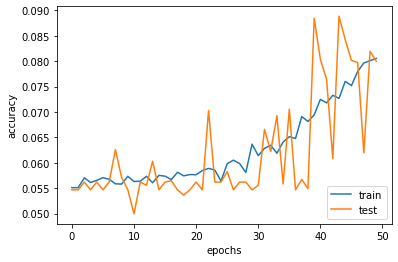

In [ ]:
print("Best validation accuracy: {:0.3f}".format(np.max(history4.history['val_accuracy'])))

plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

### Final Model, Goal of >=98% Accuracy

Using data augmentation requires more than 50 epochs to achieve higher accuracy. In this case the accuracy was much lower than the baseline models after 50 epochs, so I commented out the data augmentation. This model has an extra Dense layer with 512 neurons in between the Flatten and Dropout layers.

I tried a larger batch size of 256, 128, and 64. 256 led to worse results across the board and 128 was a minor improvement upon the 3rd baseline model. Using a batch size of 64 was a minor improvement over the 128 batch size.

In [ ]:
# reset class weight
# Calculate the class weight by dividing each class count by the sum of all class counts
class_weight = {c:dist[c]/np.sum(dist) for c in classes}

# Add data augmentation
batch_size = 64
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    # rotation_range = 5,
    # width_shift_range = 0.1,
    # height_shift_range = 0.1,
) 

test_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow(
    np.array(x_train),
    to_categorical(y_train),
    batch_size = batch_size
)
test_generator = test_datagen.flow(
    np.array(x_test),
    to_categorical(y_test),
    batch_size = batch_size
)

def final_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_size, img_size, 3)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes, activation='softmax'))
  return model

final_model = final_model()
final_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 14400)             0         
                                                                 
 dense_11 (Dense)            (None, 512)               7373312   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
final_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=METRICS)

In [ ]:
history_final = final_model.fit(
    train_generator,
    validation_data = test_generator,
    class_weight = class_weight,
    epochs = 50,
    verbose = 0)

In [ ]:
final_results = final_model.evaluate(test_generator, batch_size=batch_size, verbose=1)
for name, value in zip(final_model.metrics_names, final_results):
  print(name, ': ', value)

122/122 [==============================] - 2s 13ms/step - loss: 0.0848 - cat_acc: 0.9836 - precision: 0.9853 - recall: 0.9829 - auc: 0.9977 - top3_acc: 0.9951 - accuracy: 0.9836
loss :  0.08476873487234116
cat_acc :  0.983589768409729
precision :  0.9853489398956299
recall :  0.9829487204551697
auc :  0.9977131485939026
top3_acc :  0.9951282143592834
accuracy :  0.983589768409729


Best validation accuracy: 0.986


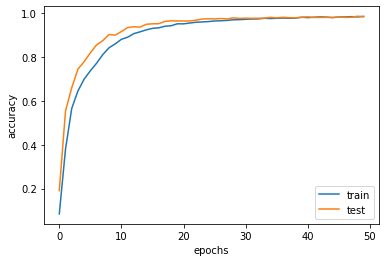

In [ ]:
print("Best validation accuracy: {:0.3f}".format(np.max(history_final.history['val_accuracy'])))

plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

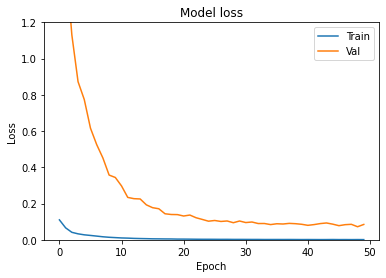

In [ ]:
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylim(top=1.2, bottom=0)
plt.show()

### Model that the book uses for 99% Accuracy

I included the model that the book uses to show how they achieved 99% accuracy. I did train over 100 epochs, which took a long time! I also wanted to show that I didn't just copy their model to do my final project :-).

In [ ]:
batch_size = 256
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 5,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
) 

test_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow(
    np.array(x_train),
    to_categorical(y_train),
    batch_size = batch_size
)
test_generator = test_datagen.flow(
    np.array(x_test),
    to_categorical(y_test),
    batch_size = batch_size
)

In [ ]:
def model5():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(768, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [ ]:
model5 = model5()
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        51264     
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 768)               38535936  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense_1 (Dense)             (None, 43)                33067     
                                                                 
Total params: 38,622,699
Trainable params: 38,622,699
No

In [ ]:
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'
METRICS = [
      keras.metrics.CategoricalAccuracy(name='cat_acc'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      top3_acc,
      'accuracy',
]

model5.compile(optimizer=Adam(),
               loss='categorical_crossentropy',
               metrics=METRICS)

In [ ]:
history5 = model5.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // batch_size,
    validation_data = test_generator,
    validation_steps = len(x_test) // batch_size,
    class_weight = class_weight,
    epochs = 100,
    verbose = 2)

Epoch 1/100
122/122 - 36s - loss: 0.1119 - cat_acc: 0.0695 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7105 - prc: 0.0537 - top3_acc: 0.1940 - accuracy: 0.0695 - val_loss: 3.4524 - val_cat_acc: 0.1217 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7461 - val_prc: 0.0754 - val_top3_acc: 0.2578 - val_accuracy: 0.1217 - 36s/epoch - 299ms/step
Epoch 2/100
122/122 - 22s - loss: 0.1021 - cat_acc: 0.1290 - precision: 0.6196 - recall: 0.0055 - auc: 0.7592 - prc: 0.0942 - top3_acc: 0.2905 - accuracy: 0.1290 - val_loss: 3.0979 - val_cat_acc: 0.2045 - val_precision: 0.8083 - val_recall: 0.0367 - val_auc: 0.8061 - val_prc: 0.1831 - val_top3_acc: 0.4224 - val_accuracy: 0.2045 - 22s/epoch - 180ms/step
Epoch 3/100
122/122 - 22s - loss: 0.0803 - cat_acc: 0.2683 - precision: 0.6217 - recall: 0.0871 - auc: 0.8461 - prc: 0.2404 - top3_acc: 0.4740 - accuracy: 0.2683 - val_loss: 2.0356 - val_cat_acc: 0.4332 - val_precision: 0.7883 - val_recall: 0.2351 - val_auc: 0.9224 - val_pr

In [ ]:
baseline_results5 = model5.evaluate(test_generator, batch_size=batch_size, verbose=1)
for name, value in zip(model5.metrics_names, baseline_results5):
  print(name, ': ', value)

32/32 [==============================] - 2s 43ms/step - loss: 0.0280 - cat_acc: 0.9936 - precision: 0.9947 - recall: 0.9922 - auc: 0.9996 - prc: 0.9989 - top3_acc: 0.9994 - accuracy: 0.9936
loss :  0.028005976229906082
cat_acc :  0.9935776591300964
precision :  0.994697630405426
recall :  0.9921924471855164
auc :  0.9996123909950256
prc :  0.9989137649536133
top3_acc :  0.9993703365325928
accuracy :  0.9935776591300964


Best validation accuracy: 0.994


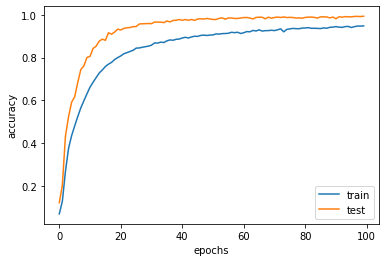

In [ ]:
print("Best validation accuracy: {:0.3f}".format(np.max(history5.history['val_accuracy'])))

plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

## 7. Overall Conclusions and Recommendations

I think the most important observation is that adding data augmentation actually decreased the metrics values when training over 50 epochs while the model that the book uses to achieve 99% accuracy use data augmentation and train over 100 epochs. This makes sense because data augmentation is a technique to combat over fitting which is a common problem for smaller datasets.

The other major conclusion is that a simple baseline CNN model performs extremely well on this image classification problem.

      Baseline #1
      loss :  0.25243934988975525
      cat_acc :  0.948846161365509
      precision :  0.9601150751113892
      recall :  0.9412820339202881
      auc :  0.9937134385108948
      top3_acc :  0.9852564334869385
      accuracy :  0.948846161365509

      Baseline #2
      loss :  0.2846887707710266
      cat_acc :  0.9700000286102295
      precision :  0.9708338975906372
      recall :  0.9687179327011108
      auc :  0.9922009706497192
      top3_acc :  0.9919230937957764
      accuracy :  0.9700000286102295

      Baseline #3
      loss :  0.10579825192689896
      cat_acc :  0.9812820553779602
      precision :  0.9828938841819763
      recall :  0.9797435998916626
      auc :  0.9967831373214722
      top3_acc :  0.9951282143592834
      accuracy :  0.9812820553779602

      Final:
      loss :  0.08476873487234116
      cat_acc :  0.983589768409729
      precision :  0.9853489398956299
      recall :  0.9829487204551697
      auc :  0.9977131485939026
      top3_acc :  0.9951282143592834
      accuracy :  0.983589768409729

It's quite interesting that this baseline cnn achieves a top 3 accuracy score of 98.5% along with a top accuracy score of 96.5%. This means that the correct prediction is in the top 3 predictions 98.5% of the time. Now this seems very good, but when we think about the real-world application of this image classification, this may not be all that great. If you had a self-driving car, incorrectly classifying a stop sign, even once, could have disastrous consequences. 